#Importing Libraries

In [9]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.9 MB/s eta 0:00:00


In [10]:
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import ultralytics
from ultralytics import YOLO
import os
import shutil
import os
import cv2
import random
from google.colab.patches import cv2_imshow

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [1]:
# --------------------------
# Download the dataset from Kaggle
# --------------------------

In [25]:
# Download latest version
path = kagglehub.dataset_download("prakharsinghchouhan/dataset-english")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'dataset-english' dataset.
Path to dataset files: /kaggle/input/dataset-english


In [26]:
# Define archive path
archive_path = os.path.join(path, "archive")
print("Archive path:", archive_path)

print("Inside archive:", os.listdir(archive_path))


Archive path: /kaggle/input/dataset-english/archive
Inside archive: ['data.yaml', 'valid', 'test', 'train']


In [27]:
# Source and destination paths for copying dataset
src = "/kaggle/input/dataset-english/archive"  # current folder
dst = "/content/dataset-english"               # destination in /content

# Copy everything
shutil.copytree(src, dst, dirs_exist_ok=True)

print("Copied to:", dst)
print("Contents:", os.listdir(dst))


Copied to: /content/dataset-english
Contents: ['train', 'test', 'valid', 'data.yaml']


In [2]:
# --------------------------
# Load YOLO model and train
# --------------------------

In [11]:
model=YOLO("yolo11n.pt")

In [34]:
model.train(data="/content/dataset-english/data.yaml",epochs=50)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset-english/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True,

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d2dbba30ef0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.04504

In [4]:
# Save the trained model

In [12]:
model.save("Road_Lane_Detector.pt")

In [80]:
# --------------------------
# Classes
# --------------------------
classes = ['BUS LANE', 'Yellow Markings', 'Line 1', 'Line 2', 'Crossing', 'Romb',
           'SLOW', 'Left Arrow', 'Forward Arrow', 'Forward Arrow -Left',
           'Forward Arrow -Right', 'Right Arrow', 'Bicycle']

# --------------------------
# Random light color for mask
# --------------------------
def random_light_color():
    return [random.randint(150, 255) for _ in range(3)]

# --------------------------
# Random dark color for labels
# --------------------------
def random_dark_color():
    return [random.randint(0, 100) for _ in range(3)]

In [77]:
# --------------------------
# Mask + bounding box with dark labels
# --------------------------
def mask_and_transparent_box(image, detections, mask_alpha=0.3, box_thickness=3):

    output = image.copy()

    for det in detections:
        x1, y1, x2, y2 = map(int, det['bbox'])
        cls_name = det['class']

        # Random colors
        mask_color = random_light_color()       # light for mask
        box_color = [random.randint(0, 255) for _ in range(3)]  # solid box random
        label_color = random_dark_color()       # dark for label

        # ---------------- Solid bounding box ----------------
        cv2.rectangle(output, (x1, y1), (x2, y2), box_color, box_thickness)

        # ---------------- Transparent mask inside box ----------------
        overlay = output.copy()
        cv2.rectangle(overlay, (x1, y1), (x2, y2), mask_color, -1)
        cv2.addWeighted(overlay, mask_alpha, output, 1 - mask_alpha, 0, output)

        # ---------------- Label ----------------
        # Slightly larger font (0.7) and thickness (2)
        cv2.putText(output, cls_name, (x1, y1-7), cv2.FONT_HERSHEY_SIMPLEX,
                    0.7, label_color, 2, cv2.LINE_AA)

    return output



In [78]:
# --------------------------
# Predict images or video
# --------------------------
def predict_random_images_or_video(model_path, source_path, num_images=10,
                                   mask_alpha=0.3, box_thickness=3, show=True, output_folder="predictions"):

    os.makedirs(output_folder, exist_ok=True)
    model = YOLO(model_path)


    if source_path.lower().endswith(('.mp4', '.avi', '.mov', '.mkv')):
        cap = cv2.VideoCapture(source_path)
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out_path = os.path.join(output_folder, "pred_video.mp4")
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        out = cv2.VideoWriter(out_path, fourcc, fps, (width, height))

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            results = model(frame)[0]
            detections = []
            for box, cls_id in zip(results.boxes.xyxy, results.boxes.cls):
                x1, y1, x2, y2 = box.cpu().numpy()
                cls_name = classes[int(cls_id)]
                detections.append({'bbox':[x1, y1, x2, y2], 'class':cls_name})

            output_frame = mask_and_transparent_box(frame, detections, mask_alpha=mask_alpha, box_thickness=box_thickness)
            out.write(output_frame)
            if show:
                cv2_imshow(output_frame)

        cap.release()
        out.release()
        print(f"Video saved at: {out_path}")

    else:
        all_files = [f for f in os.listdir(source_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if len(all_files) < num_images:
            num_images = len(all_files)
        random_files = random.sample(all_files, num_images)

        for img_name in random_files:
            img_path = os.path.join(source_path, img_name)
            frame = cv2.imread(img_path)
            results = model(frame)[0]

            detections = []
            for box, cls_id in zip(results.boxes.xyxy, results.boxes.cls):
                x1, y1, x2, y2 = box.cpu().numpy()
                cls_name = classes[int(cls_id)]
                detections.append({'bbox':[x1, y1, x2, y2], 'class':cls_name})

            output_frame = mask_and_transparent_box(frame, detections, mask_alpha=mask_alpha, box_thickness=box_thickness)
            out_path = os.path.join(output_folder, f"pred_{img_name}")
            cv2.imwrite(out_path, output_frame)
            if show:
                cv2_imshow(output_frame)
            print(f"Saved: {out_path}")

    print("Prediction completed.")

In [5]:
# --------------------------
# Test predictions on random images
# --------------------------


0: 640x640 4 Line 1s, 1 Line 2, 1 Left Arrow, 11.4ms
Speed: 2.5ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


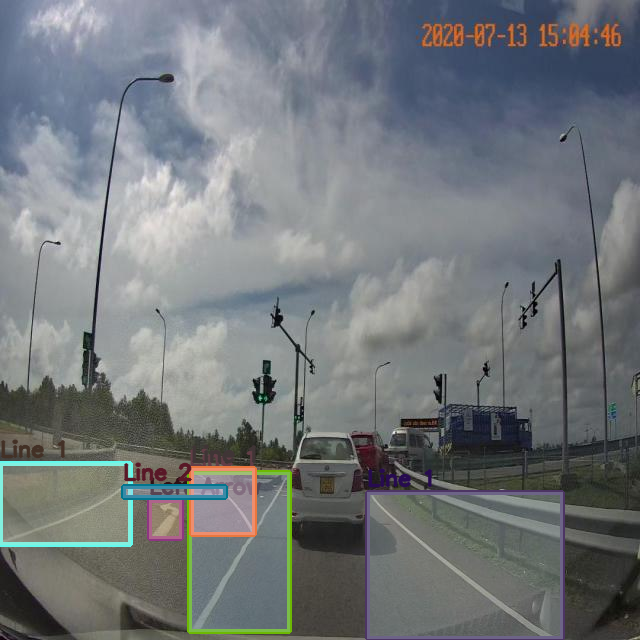

Saved: predictions/pred_487b_jpg.rf.c1b15f4031ff4ae4aaf6da81a2dc32b9.jpg

0: 640x640 1 Forward Arrow, 1 Forward Arrow -Right, 14.3ms
Speed: 2.2ms preprocess, 14.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


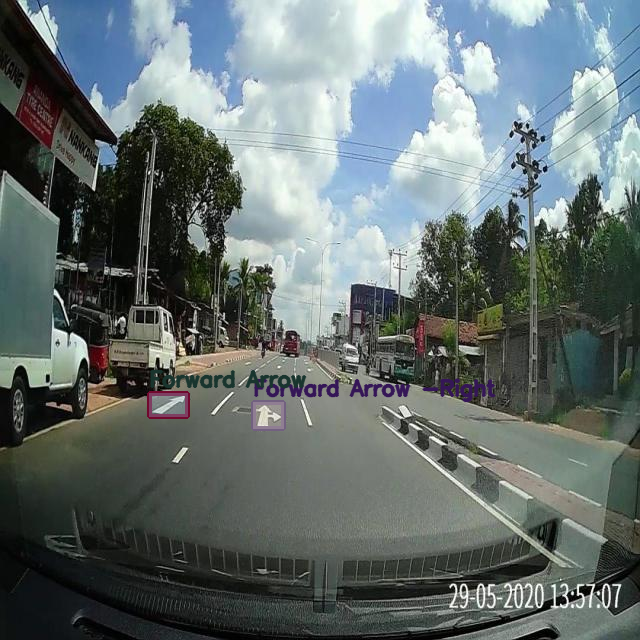

Saved: predictions/pred_613a_jpg.rf.3d1edda62e7ff0e089b4ef5081844890.jpg

0: 640x640 5 Line 1s, 1 Left Arrow, 4 Forward Arrows, 14.7ms
Speed: 2.0ms preprocess, 14.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


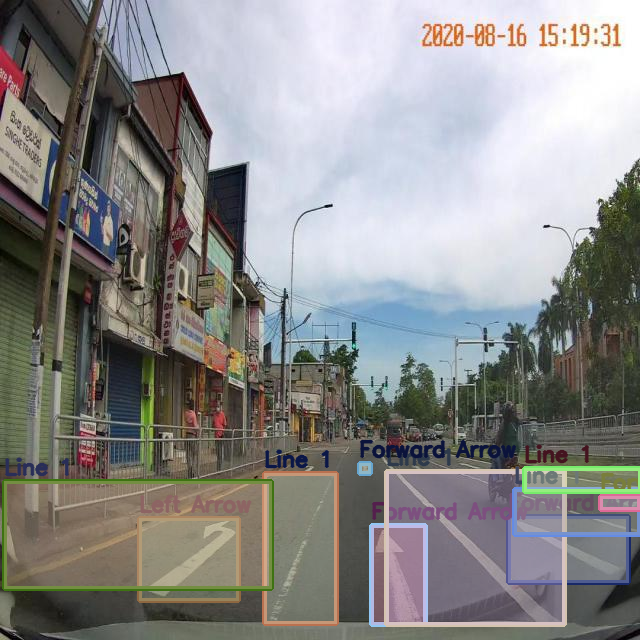

Saved: predictions/pred_164c_jpg.rf.778ad1d0e31b086c28719721d7eb01c2.jpg

0: 640x640 1 Romb, 11.2ms
Speed: 2.3ms preprocess, 11.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


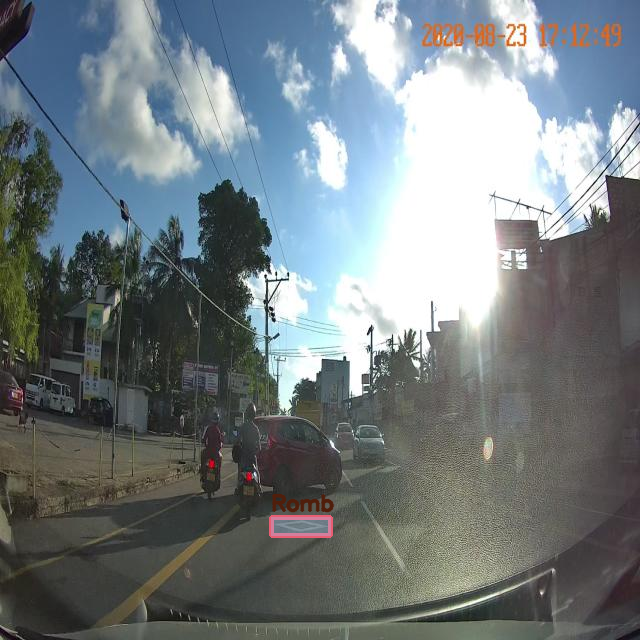

Saved: predictions/pred_259a_jpg.rf.0bfdd89ac9fbadb426af1c640149893b.jpg

0: 640x640 7 Line 1s, 2 Rombs, 11.6ms
Speed: 2.4ms preprocess, 11.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


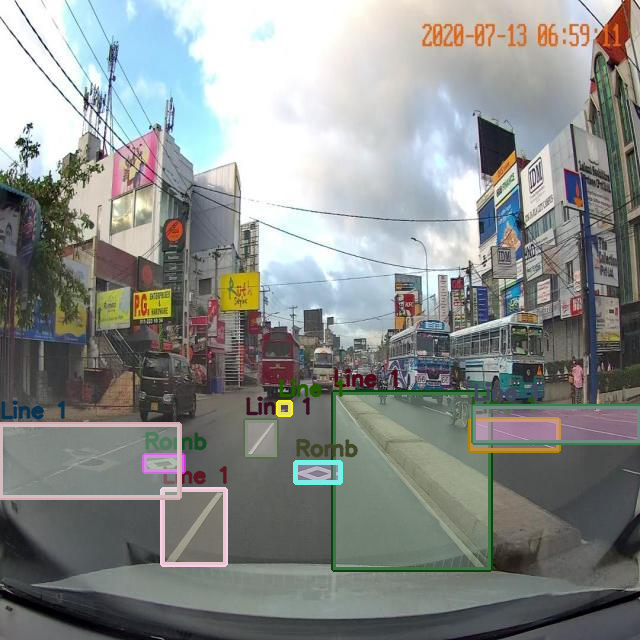

Saved: predictions/pred_271_jpg.rf.23e92190117578ef4e13be3cd24bc872.jpg

0: 640x640 (no detections), 12.4ms
Speed: 2.3ms preprocess, 12.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


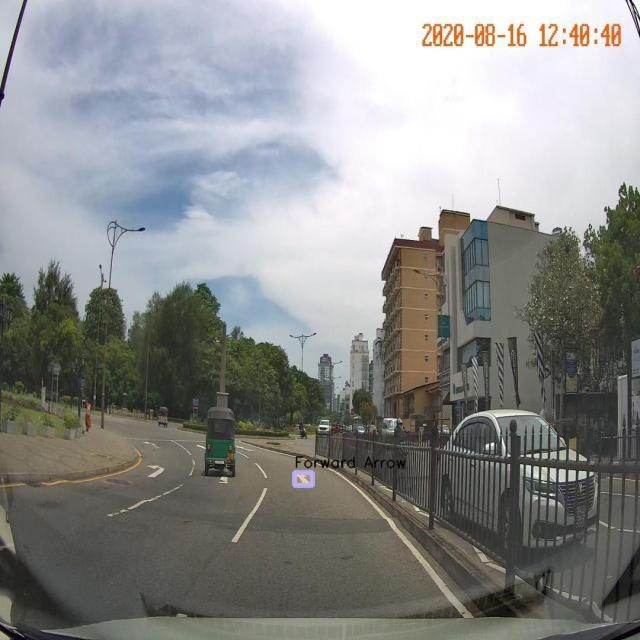

Saved: predictions/pred_pred_67a_jpg.rf.ab9a6a1bd7adf67be9a0e0f59b366aa4.jpg

0: 640x640 1 Crossing, 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


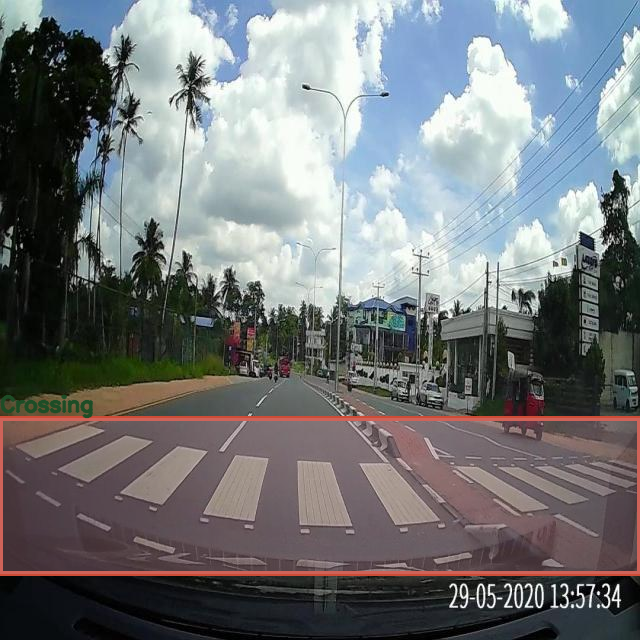

Saved: predictions/pred_618d_jpg.rf.d38d46eb7404d89f00ba521bfa97c3db.jpg

0: 640x640 1 Forward Arrow, 1 Forward Arrow -Right, 2 Right Arrows, 12.5ms
Speed: 2.1ms preprocess, 12.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


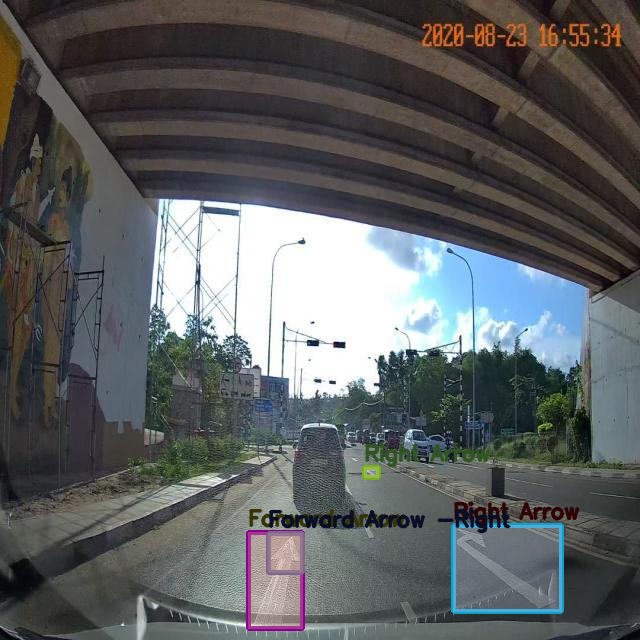

Saved: predictions/pred_239c_jpg.rf.c306ba866a8f81c260e426ada55f5f7e.jpg

0: 640x640 1 BUS LANE, 4 Line 1s, 1 Forward Arrow, 13.6ms
Speed: 2.1ms preprocess, 13.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


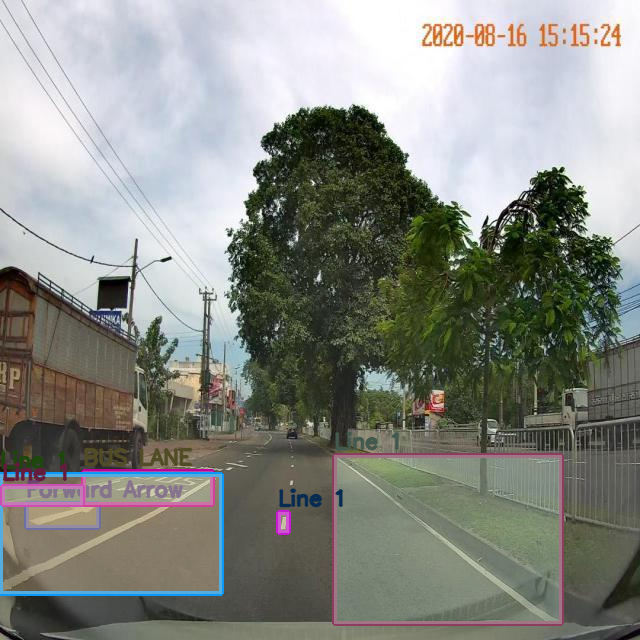

Saved: predictions/pred_121_jpg.rf.dbe000cc9ea365a20dc4edc2348dd9bc.jpg

0: 640x640 1 Crossing, 15.9ms
Speed: 2.3ms preprocess, 15.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


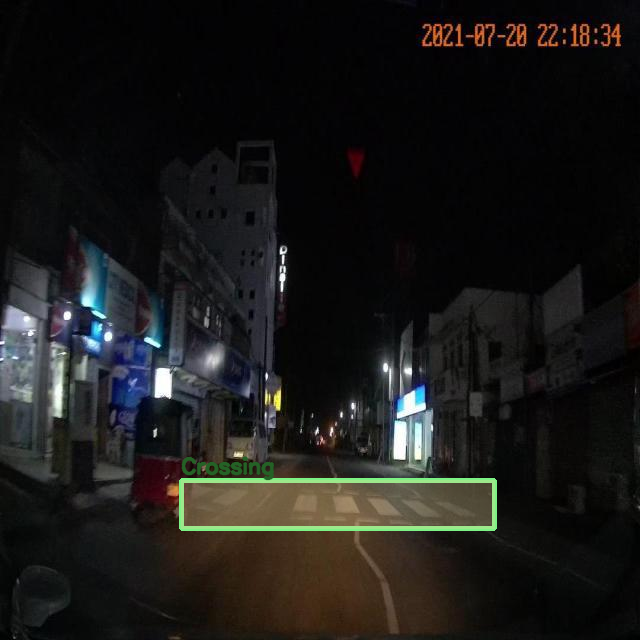

Saved: predictions/pred_727b_jpg.rf.f983be924268e257476b3c6c311bdd0e.jpg
Prediction completed.


In [79]:
test_folder = "/content/dataset-english/test/images"
model_path = "/content/Road_Lane_Detector.pt"

predict_random_images_or_video(model_path, test_folder, num_images=10,
                               mask_alpha=0.3, box_thickness=3, show=True)


In [6]:
# --------------------------
# Test predictions on video
# --------------------------

In [74]:
video_path = "/content/Screen Recording 2025-12-06 162653.mp4"
model_path = "/content/Road_Lane_Detector.pt"

predict_random_images_or_video(model_path, video_path,
                               mask_alpha=0.3, box_thickness=3, show=False)



0: 384x640 (no detections), 8.9ms
Speed: 2.3ms preprocess, 8.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 11.7ms
Speed: 5.8ms preprocess, 11.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 16.2ms
Speed: 3.9ms preprocess, 16.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 11.7ms
Speed: 4.1ms preprocess, 11.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 14.7ms
Speed: 4.4ms preprocess, 14.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 9.0ms
Speed: 3.3ms preprocess, 9.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 12.3ms
Speed: 3.8ms preprocess, 12.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 13.1ms
Speed: 3.7ms preprocess, 13.1ms infer